In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import math

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
# from sklearn.svm import SVR  will cost too much time
import xgboost as xgb    
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# the factors that may infect the user rate:

# price

# freight_value

# product category

# duration from purchase to delivery to the customer

# the description of the purchase

# if the delivery of order is late

# if the customer write the comment

# the number of products in one order

# total price in one order

In [ ]:
# run this if you use connection to your google drive
order_reviews = pd.read_csv('drive/Shared drives/671 final project/datasets/olist_order_reviews_dataset.csv')
orders_dataset = pd.read_csv('drive/Shared drives/671 final project/datasets/olist_orders_dataset.csv')
order_items_dataset = pd.read_csv('drive/Shared drives/671 final project/datasets/olist_order_items_dataset.csv')
# customers_dataset = pd.read_csv('drive/Shared drives/671 final project/datasets/olist_customers_dataset.csv')
order_payments = pd.read_csv('drive/Shared drives/671 final project/datasets/olist_order_payments_dataset.csv')
products_dataset = pd.read_csv('drive/Shared drives/671 final project/datasets/olist_products_dataset.csv')
product_category_en = pd.read_csv('drive/Shared drives/671 final project/datasets/product_category_name_translation.csv')

In [ ]:
# # What is the difference between payment_value and price?
# temp1 = order_payments.merge(orders_dataset,on='order_id').merge(order_items_dataset,on='order_id')
# temp1.head()

# # payment_value = price + freight_value when pay_seq = 1

# feature engineer

In [ ]:
order_item_temp1 = order_items_dataset.groupby('order_id').agg({'order_item_id':'count','seller_id':'count','price':'sum','freight_value':'sum'}).reset_index()
order_item_temp1.columns = ['order_id','num_of_products','num_of_sellers','tot_price', 'tot_freight_value']

In [ ]:
order_item_temp1.head()

,order_id,num_of_products,num_of_sellers,tot_price,tot_freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,1,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,1,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,1,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,1,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,1,199.90,18.14


In [ ]:
# if the customer paid the money in one time
order_payments_temp1 = order_payments.groupby('order_id').count()[['payment_sequential']].reset_index()
order_payments_temp1.columns = ['order_id','payment_times']

In [ ]:
# if the order have more than one review
order_reviews.groupby('order_id').count()[['review_id']].value_counts()

review_id
1            98886
2              551
3                4
dtype: int64

In [ ]:
order_reviews_temp1 = order_reviews.groupby('order_id').count()[['review_id']].reset_index()
order_reviews_temp1.columns = ['order_id','tot_reviews']

In [ ]:
# the amount of order id a product exists
order_item_temp2 = order_items_dataset.groupby('product_id').count()[['order_id']].reset_index()
order_item_temp2.columns = ['product_id','product_tot_orders']

In [ ]:
temp2 = order_payments.merge(orders_dataset,on='order_id').merge(order_reviews,on='order_id').merge(order_items_dataset,on='order_id').merge(order_item_temp1,on='order_id')\
.merge(products_dataset,on='product_id').merge(product_category_en,on='product_category_name').merge(order_payments_temp1,on='order_id').merge(order_reviews_temp1,on='order_id')\
.merge(order_item_temp2,on='product_id')

In [ ]:
temp2['if_comment'] = [1 if x is not np.nan else 0 for x in temp2.review_comment_message]

In [ ]:
temp2.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,num_of_products,num_of_sellers,tot_price,tot_freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,payment_times,tot_reviews,product_tot_orders,if_comment
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22 00:00:00,4ce650e117a5b292bf5ea980a61eb61e,1,Não recomendo,"Produto com qualidade ruim, amassado e descasc...",2018-05-10 00:00:00,2018-05-15 23:38:00,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.80,19.53,1,1,79.80,19.53,casa_construcao,57.0,921.0,8.0,800.0,17.0,27.0,17.0,home_construction,1,1,2,1
1,d86305c284cecff56c7ee9d3fbd4f8d6,1,credit_card,4,93.72,0e37385834260d6111727103a93e790a,delivered,2018-04-15 22:53:59,2018-04-15 23:10:32,2018-04-16 23:54:55,2018-04-20 00:07:39,2018-05-09 00:00:00,ec9d84039245b981ebdbf7d16c723b6e,4,NaN,NaN,2018-04-21 00:00:00,2018-04-21 10:31:10,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-04-19 23:10:02,79.80,13.92,1,1,79.80,13.92,casa_construcao,57.0,921.0,8.0,800.0,17.0,27.0,17.0,home_construction,1,1,2,0
2,b545ba7b0bd67a3128185c7214704319,1,credit_card,8,340.08,7e2ca73af071679902a9ba14d7c3cee8,delivered,2018-06-11 14:59:24,2018-06-11 16:31:42,2018-06-12 14:15:00,2018-06-18 16:41:04,2018-07-04 00:00:00,5f65ad4b5147b940da2da6802f18bbf7,4,NaN,NaN,2018-06-19 00:00:00,2018-06-19 20:20:45,1,2233b59e8cf2817f9659e52cce3093de,e3d3b3efac954a60d61be70b7e05b49b,2018-06-15 15:20:20,316.05,24.03,1,1,316.05,24.03,casa_construcao,58.0,1624.0,3.0,9350.0,20.0,20.0,20.0,home_construction,1,1,1,0
3,6a26bd1a037993f1205073dbeda67db4,1,credit_card,2,67.12,2a44b3dbad360783fd663c15c3e6367c,delivered,2018-02-15 13:53:42,2018-02-15 14:10:28,2018-02-16 22:38:59,2018-03-02 22:29:04,2018-03-08 00:00:00,fad89f16742c04dcdfec38fd6c115561,4,NaN,"Otimo produto recebir no prazo certo,recomento",2018-03-03 00:00:00,2018-03-04 20:25:59,1,679a3e5e1d2bb68982be5734c6e55e63,8a130737016f838139d31878787a39c9,2018-02-21 13:10:28,54.40,12.72,1,1,54.40,12.72,casa_construcao,57.0,565.0,4.0,800.0,38.0,38.0,22.0,home_construction,1,1,29,1
4,1d84d00f6d2334d63f35ba528cd0d99d,1,boleto,1,63.74,488f8793429e555fbc1204d10bf0f5f9,delivered,2018-02-10 16:50:42,2018-02-16 07:56:27,2018-02-16 22:38:54,2018-02-21 01:26:56,2018-02-26 00:00:00,20e6537d2c1fb427d85b2d17a650a466,5,NaN,NaN,2018-02-22 00:00:00,2018-02-24 12:25:04,1,679a3e5e1d2bb68982be5734c6e55e63,8a130737016f838139d31878787a39c9,2018-02-22 06:56:27,54.40,9.34,1,1,54.40,9.34,casa_construcao,57.0,565.0,4.0,800.0,38.0,38.0,22.0,home_construction,1,1,29,0


In [ ]:
# temp2.columns

Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'order_item_id',
       'product_id', 'seller_id', 'shipping_limit_date', 'price',
       'freight_value', 'num_of_products', 'num_of_sellers', 'tot_price',
       'tot_freight_value', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'payment_times', 'tot_reviews',
       'product_tot_orders', 'if_comment'],
      dtype='object')

In [ ]:
# columns we need to predict the review score
colname = ['payment_value', 'order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date','review_score','shipping_limit_date','price','freight_value','num_of_products',
           'num_of_sellers','tot_price','tot_freight_value', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g','product_length_cm', 'product_height_cm', 
           'product_width_cm', 'product_category_name_english', 'payment_times','tot_reviews','product_tot_orders', 'if_comment']

temp3 = temp2[colname].copy()

In [ ]:
temp3.duplicated().unique()

array([False,  True])

In [ ]:
# drop duplicates
temp3.drop_duplicates(inplace=True,ignore_index=True)

In [ ]:
temp3.isna().sum()

payment_value                       0
order_approved_at                  13
order_delivered_carrier_date     1040
order_delivered_customer_date    2276
order_estimated_delivery_date       0
review_score                        0
shipping_limit_date                 0
price                               0
freight_value                       0
num_of_products                     0
num_of_sellers                      0
tot_price                           0
tot_freight_value                   0
product_name_lenght                 0
product_description_lenght          0
product_photos_qty                  0
product_weight_g                    1
product_length_cm                   1
product_height_cm                   1
product_width_cm                    1
product_category_name_english       0
payment_times                       0
tot_reviews                         0
product_tot_orders                  0
if_comment                          0
dtype: int64

In [ ]:
temp3.dropna(inplace=True)

In [ ]:
temp3.shape

(102828, 25)

In [ ]:
temp3.order_approved_at = pd.to_datetime(temp3.order_approved_at)
temp3.order_delivered_carrier_date = pd.to_datetime(temp3.order_delivered_carrier_date)
temp3.order_delivered_customer_date = pd.to_datetime(temp3.order_delivered_customer_date)
temp3.order_estimated_delivery_date = pd.to_datetime(temp3.order_estimated_delivery_date)
temp3.shipping_limit_date = pd.to_datetime(temp3.shipping_limit_date)

In [ ]:
temp3['actual_delivery_duration'] = temp3.order_delivered_customer_date - temp3.order_approved_at
temp3['actual_delivery_duration'] = temp3['actual_delivery_duration'].apply(lambda x: x.total_seconds())
temp3['estimated_delivery_duration'] = temp3.order_estimated_delivery_date - temp3.order_approved_at
temp3['estimated_delivery_duration'] = temp3['estimated_delivery_duration'].apply(lambda x: x.total_seconds())
temp3['purchase_carrier_duration'] = temp3.order_estimated_delivery_date - temp3.order_approved_at
temp3['purchase_carrier_duration'] = temp3['purchase_carrier_duration'].apply(lambda x: x.total_seconds())
temp3['purchase_shipping_limit'] = temp3.shipping_limit_date - temp3.order_approved_at
temp3['purchase_shipping_limit'] = temp3['purchase_shipping_limit'].apply(lambda x: x.total_seconds())
temp3.drop(columns=['order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date','shipping_limit_date'],inplace=True)

In [ ]:
temp3['diff_estimated_actual_delivery'] = temp3['estimated_delivery_duration'] - temp3['actual_delivery_duration']
temp3['is_late'] = np.where(temp3['estimated_delivery_duration'] > temp3['actual_delivery_duration'], 0, 1)  # 0 not late

In [ ]:
# the ratio of the freight:price
temp3['freight2price'] = temp3.freight_value/temp3.price

In [ ]:
def onehotenc(df_cat):
  enc = OneHotEncoder(handle_unknown='ignore').fit(df_cat)
  col_names = enc.get_feature_names(df_cat.columns)
  output = pd.DataFrame(enc.transform(df_cat).toarray(),columns=col_names)
  return output

def labelenc(df_cat):
  for col in df_cat.columns:
    df_cat[col] = LabelEncoder().fit_transform(df_cat[col])
  return df_cat

In [ ]:
temp3_cat = temp3[['product_category_name_english']].copy()
temp3_num = temp3.drop(columns='product_category_name_english')

temp3_cat = labelenc(temp3_cat)
temp3 = pd.concat([temp3_num,temp3_cat],axis=1)

In [ ]:
corr_matrix = temp3.corr()
corr_matrix['review_score'].sort_values(ascending=False)

review_score                      1.000000
diff_estimated_actual_delivery    0.245824
product_category_name_english     0.033318
product_description_lenght        0.018724
product_photos_qty                0.017729
payment_times                    -0.002601
price                            -0.002773
product_tot_orders               -0.004248
product_height_cm                -0.014686
product_width_cm                 -0.015917
product_name_lenght              -0.017097
tot_reviews                      -0.019853
product_length_cm                -0.021368
freight2price                    -0.026212
product_weight_g                 -0.026770
purchase_shipping_limit          -0.027212
freight_value                    -0.034431
tot_price                        -0.045173
payment_value                    -0.052606
purchase_carrier_duration        -0.056250
estimated_delivery_duration      -0.056250
tot_freight_value                -0.111594
num_of_sellers                   -0.155253
num_of_prod

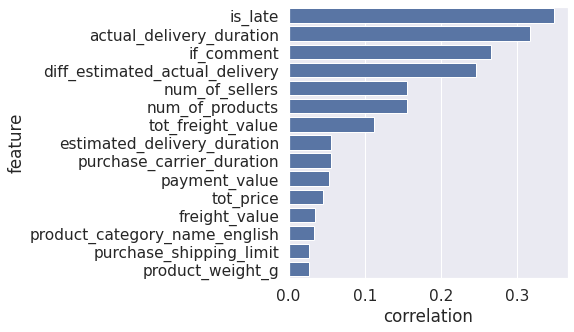

In [ ]:
temp1 = corr_matrix[['review_score']].sort_values(by='review_score')
temp1.drop(index=['review_score'],inplace=True)
temp1['correlation'] = temp1['review_score'].apply(lambda x: abs(x))
temp1.reset_index(inplace=True)
temp1.rename(columns={'index':'feature'},inplace=True)

sns.set(rc={'figure.figsize':(5,5)})
sns.set(font_scale = 1.4)
sns_plot = sns.barplot(y="feature", x="correlation", data=temp1.sort_values(by='correlation',ascending=False).iloc[:15], color='b')  # top 10 important features
# plt.savefig("feature_importance.png")  # cannot save the whole image, part of the label text will lose
plt.show()
# sns_plot.figure.savefig("feature_importance.png")

In [ ]:
# corr_matrix['review_score'].sort_values(ascending=False).index

Index(['review_score', 'diff_estimated_actual_deliery',
       'product_category_name_english', 'product_description_lenght',
       'product_photos_qty', 'payment_times', 'price', 'product_tot_orders',
       'product_height_cm', 'product_width_cm', 'product_name_lenght',
       'tot_reviews', 'product_length_cm', 'freight2price', 'product_weight_g',
       'purchase_shipping_limit', 'freight_value', 'tot_price',
       'payment_value', 'purchase_carrier_duration',
       'estimated_delivery_duration', 'tot_freight_value', 'num_of_sellers',
       'num_of_products', 'if_comment', 'actual_delivery_duration', 'is_late'],
      dtype='object')

# Machine learning models

In [ ]:
X = temp3.drop(columns=['review_score',]) 
y = temp3[['review_score']]

In [ ]:
X_train_val,X_test,y_train_val,y_test = train_test_split(X,y,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train_val,y_train_val,test_size=0.2)

In [ ]:
def regression_model(reg_model):
  pipe = Pipeline([('scaler1', MinMaxScaler()),('scaler2', StandardScaler()), ('reg',reg_model)])
  pipe.fit(X_train,y_train)
  y_val_pred = pipe.predict(X_val)
  mae = mean_absolute_error(y_val,y_val_pred)
  mse = mean_squared_error(y_val,y_val_pred)
  rmse = np.sqrt(mse)
  return mae, rmse

In [ ]:
!pip install mord

  Created wheel for mord: filename=mord-0.6-cp36-none-any.whl size=6009 sha256=f843ea72e395d8026491f8e4d435fcda7d2369eb470c251ee30a73ceaa45f3a6
  Stored in directory: /root/.cache/pip/wheels/98/14/b2/244c2cec93a0c6edb29b488bd6b2710ded7e9d457033b86366
Successfully built mord


In [ ]:
import mord 

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=0, n_estimators = 50)
mul_lr = mord.OrdinalRidge(alpha=0.001, 
 							fit_intercept=True, 
						 	normalize=False, 
 							copy_X=True, 
 							max_iter=None, 
 							tol=0.001, 
 							solver='auto')
ml_models = [DummyRegressor(strategy='mean'),KNeighborsRegressor(),xg_reg,AdaBoostRegressor(),GradientBoostingRegressor(),
             RandomForestRegressor(),LinearRegression(),Lasso(),Ridge(),mul_lr,MLPRegressor()]

In [ ]:
performance = []
for model in ml_models:
  print(ml_models.index(model)+1)
  performance.append(regression_model(model))

1
2
3
4
5
6
7
8
9
10
11


In [ ]:
performance_df = pd.DataFrame(performance, columns=['MAE','RMSE'])
performance_df['Regression_models'] = ['Dummy','KNN','XGBoost','AdaBoost','GradientBoost','RandomForest','Linear','Lasso','Ridge','OrdinalLogistic','MLP']
performance_df = performance_df[['Regression_models','MAE','RMSE']]

In [ ]:
performance_df

,Regression_models,MAE,RMSE
0,Dummy,1.042430,1.333342
1,KNN,0.894803,1.221825
2,XGBoost,0.887444,1.136202
3,AdaBoost,0.974353,1.174421
4,GradientBoost,0.877496,1.132129
5,RandomForest,0.856854,1.113880
6,Linear,0.917794,1.179364
7,Lasso,1.042430,1.333342
8,Ridge,0.917935,1.179333
9,OrdinalLogistic,0.875950,1.222671


In [ ]:
(1.042430-0.856854)/1.042430

0.17802250510825665

In [ ]:
(1.333342-1.113880)/1.333342

0.16459543012970418

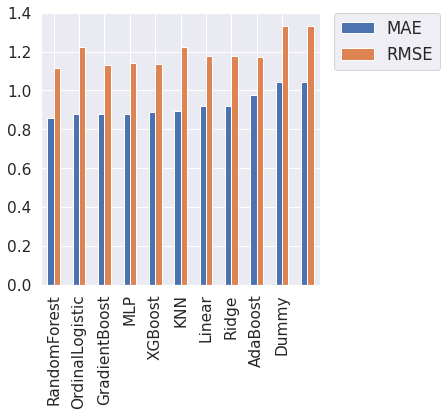

In [ ]:
performance_df.sort_values(by='MAE').plot(kind='bar')
sns.set(rc={'figure.figsize':(15,5)})
sns.set(font_scale = 1.5)
plt.xticks(range(10),performance_df.sort_values(by='MAE').Regression_models,rotation='vertical')
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)  
plt.show()

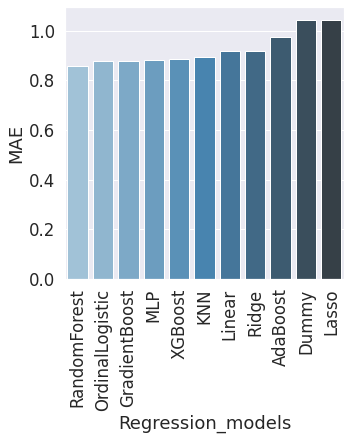

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
sns.set(font_scale = 1.5)
# f,(ax1,ax2)=plt.subplots(2,1)
sns.barplot(x='Regression_models',y='MAE',data=performance_df.sort_values(by='MAE'), palette="Blues_d")
plt.xticks(rotation='vertical')
plt.show()

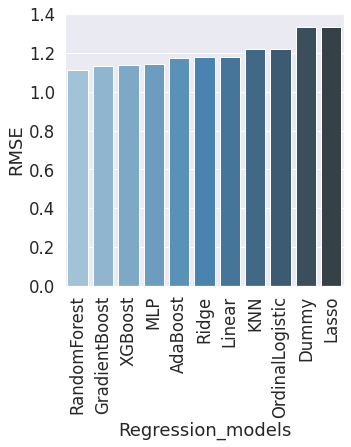

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
sns.set(font_scale = 1.5)
sns.barplot(x='Regression_models',y='RMSE',data=performance_df.sort_values(by='RMSE'), palette="Blues_d")
plt.xticks(rotation='vertical')
plt.show()

# Parameter tuning

In [ ]:
# ## RandomForest
# def param_tunning(reg_model):
#   pipe = Pipeline([('scaler1', MinMaxScaler()),('scaler2', StandardScaler()), ('reg',reg_model)])
#   pipe.fit(X_train,y_train)
#   y_train_pred = pipe.predict(X_train)
#   mae_train = mean_absolute_error(y_train,y_train_pred)
#   y_val_pred = pipe.predict(X_val)
#   mae_val = mean_absolute_error(y_val,y_val_pred)
#   # mse = mean_squared_error(y_val,y_val_pred)
#   # rmse = np.sqrt(mse)
#   return mae_train,mae_val

# estimator_list = [50,80,100,150,200]
# mae_train_list = []
# mae_val_list = []
# for estimator_num in estimator_list:
#   mae_train, mae_val = param_tunning(RandomForestRegressor(n_estimators=estimator_num))
#   mae_train_list.append(mae_train)
#   mae_val_list.append(mae_val)

# plt.plot(estimator_list,mae_train_list,color='b')
# plt.plot(estimator_list,mae_val_list,color='orange')
# plt.show()

In [ ]:
# try GridSearchCV
# Random Forest
from sklearn.model_selection import GridSearchCV
pipe = Pipeline([('scaler1', MinMaxScaler()),('scaler2', StandardScaler()), ('RF',RandomForestRegressor())])
param_grid = [{
        'RF__n_estimators' : [100,150,200],
        'RF__min_samples_leaf' : [1,3,5,10],
        }]
CV_RF = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = 'neg_mean_absolute_error')
CV_RF.fit(X_train_val, y_train_val)
print(CV_RF.best_score_)
print(CV_RF.best_params_)
y_pred = CV_RF.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(test_mae, test_rmse)

-0.8498337250779215
{'RF__min_samples_leaf': 3, 'RF__n_estimators': 200}
0.8389467676934504 1.0924994578211844


In [ ]:
# GBDT
pipe = Pipeline([('scaler1', MinMaxScaler()),('scaler2', StandardScaler()), ('GBDT',GradientBoostingRegressor())])
param_grid = [{
        'GBDT__n_estimators' : [100,150,200],
        'GBDT__min_samples_leaf' : [1,3,5,10],
        'GBDT__max_depth': [3,5,10]
        }]
CV_GBDT = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = 'neg_mean_absolute_error',cv=3)
CV_GBDT.fit(X_train_val, y_train_val)
print(CV_GBDT.best_score_)
print(CV_GBDT.best_params_)

y_pred = CV_GBDT.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(test_mae, test_rmse)

-0.8486304342104177
{'GBDT__max_depth': 10, 'GBDT__min_samples_leaf': 3, 'GBDT__n_estimators': 200}
0.8348294652632501 1.099021468040919


# Presentation

In [ ]:
temp1 = pd.DataFrame({'model':['Dummy','SVD++','RandomForest','Network\n+\nRandomForest'],
                      'MAE':[1.030636,1.0162, 0.852916, 0.841261],
                      'RMSE':[1.316716,1.3011,1.105447,1.105060]})
# sns.set(rc={'figure.figsize':(4,5)})
plt.figure(figsize=(8, 4))
sns.set(font_scale = 5)
sns.set(style="white", color_codes=True)
temp1.sort_values(by='MAE').plot(kind='bar')
# plt.xticks(range(4),temp1.sort_values(by='MAE').model,rotation='vertical')
plt.xticks(range(4),temp1.sort_values(by='MAE').model,rotation=30,fontsize=13)
# plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)  
plt.show()

In [1]:
(1.03-0.84)/1.03

0.18446601941747579